In [1]:
import networkx as nx
import tweepy
import pickle
import urllib.request
import io
from PIL import Image
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
with open('data/crawler.bin', 'rb') as fp:
    crawler = pickle.loads(fp.read())

print('#{nodes}: %d' % crawler.graph.number_of_nodes())
print('#{edges}: %d' % crawler.graph.number_of_edges())
print('visited: %d' % len(crawler.visited))

#{nodes}: 41392
#{edges}: 49590
visited: 60


In [3]:
graph = crawler.graph
ranks = nx.pagerank(graph)
ranked = list(sorted(ranks, key=ranks.get, reverse=True))
graph.remove_nodes_from(ranked[12:])

In [4]:
import config
auth = tweepy.OAuthHandler(config.consumer_key, config.consumer_secret)
auth.set_access_token(config.access_token_key, config.access_token_secret)
api = tweepy.API(auth)

In [5]:
# get screen_name and image
for user_id in graph.nodes():
    status = api.get_user(user_id)
    graph.node[user_id]['screen_name'] = status.screen_name
    file = io.BytesIO(urllib.request.urlopen(status.profile_image_url).read())
    graph.node[user_id]['image']= Image.open(file)

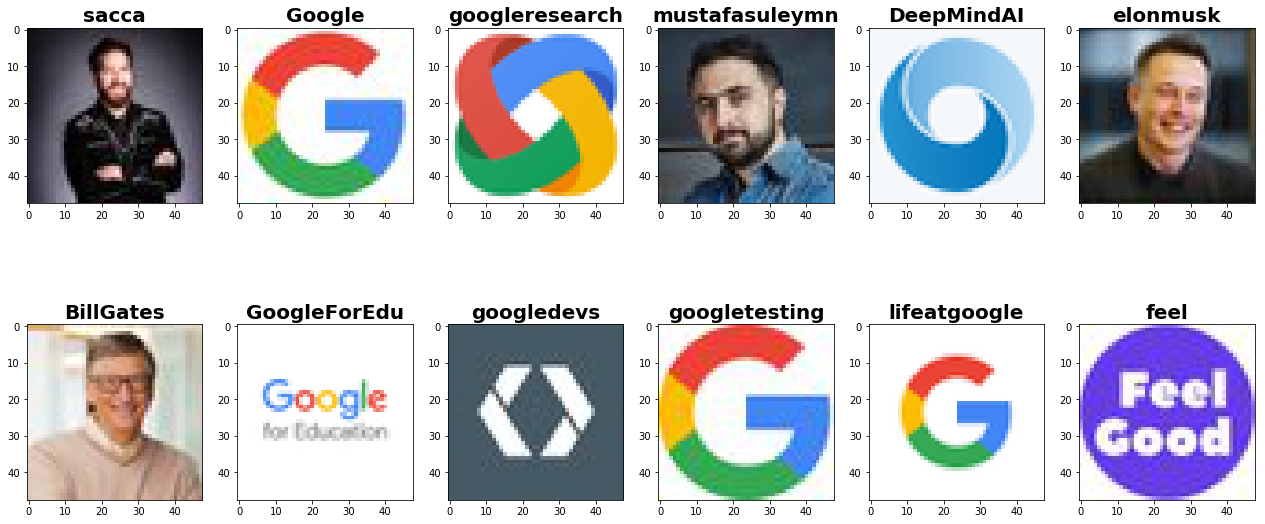

In [8]:
plt.subplots(2, 6, figsize=(22, 10))

cnt = 1
for user_id in graph.nodes():
    plt.subplot(2, 6, cnt)
    plt.title(s=graph.node[user_id]['screen_name'], fontsize=20, fontweight='bold')
    plt.imshow(graph.node[user_id]['image'])
    cnt += 1

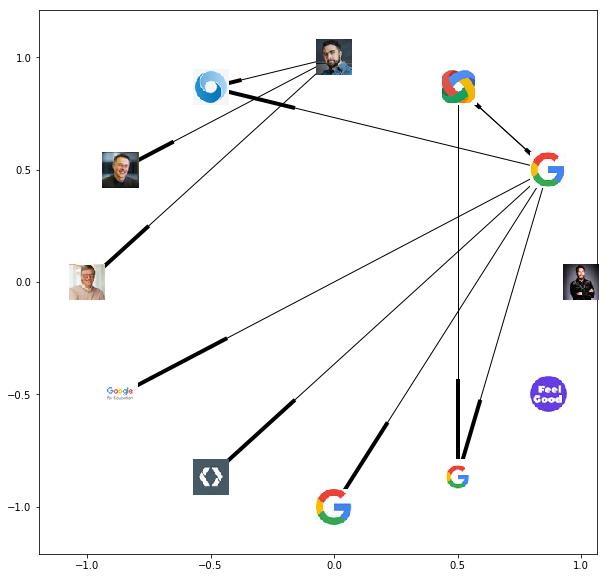

In [7]:
# pos = nx.spring_layout(graph)
pos = nx.circular_layout(graph)

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(1, 1, 1)
nx.draw_networkx_edges(graph, pos, ax=ax, arrows=True, zorder=10)

trans_data = ax.transData.transform
trans_figure_inv = fig.transFigure.inverted().transform

size = 0.05
for user_id in graph.nodes():
    x, y = trans_figure_inv(trans_data(pos[user_id]))
    rect = [x - size/2, y - size/2, size, size]
    ax_image = plt.axes(rect)
    ax_image.imshow(graph.node[user_id]['image'], zorder=1)
    ax_image.axis('off')